Checkpoints sugeridos:

1) Coleta de dados via web scrapping. Bibliotecas como Selenium e BeautifulSoup podem ajudar.

2) Análise exploratória: Gráficos de dispersão entre nota padronizada dos dois rankings. São correlacionados? Existem outliers?

3) Modelo explicativo: Regressão linear múltipla entre os 4 itens do ranking do Legisla Brasil e a nota do Ranking dos Políticos, por exemplo. Os 4 itens do Legisla explicam qual variabilidade do Ranking dos Políticos?

4) Discussão: Por que são diferentes? Por que são iguais? Existem viéses políticos? São apartidários? Qual sua opinião que justifique os resultados?

### Observações para aplicar em novas versões do modelo:

- Dividir o dataset em dois, por nota ou por ideologia do partido.
- Fazer um teste de hipóteses 
- Transformar a variável categórica em numérica e adicionar ao modelo.

### Pontuações ao longo do caminho

 - Modelos de ML, como Regressão Linear, assumem que os dados são normalmente distribuidos. Se essa suposição é falsa o modelo falha em dar predições precisas.

In [1]:
# bibliotecas
import pandas as pd #processamento de dados
import numpy as np #algebra linear
import matplotlib.pyplot as plt # Matlab-Style
from pandas.plotting import scatter_matrix 
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*arg, **kwargs):
    pass
warnings.warm = ignore_warn #ignorar avisos chatos (do sklearn e seaborn)

from scipy import stats
from scipy.stats import norm, skew #para analises estatítiscas

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # limita saídas de tipos floats 
                                                                    # a 3 casas decimais
from subprocess import check_output
print(check_output(["ls"]).decode("utf8")) #checar os arquivos disponiveis no diretório


# from sklearn import model_selection
# from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Analise_dos_dados.ipynb
BOLOGNESI_RIBEIRO_CODATO_nova+classificacao+ideologica+VERSAO+pre+print+jun2021.pdf
Busca automatica - webscraping.ipynb
MachineLearning.ipynb
Output.txt
README.md
Rank_pol_V3.ipynb
Ranking_Politicos.ipynb
Ranking_pol_site2.ipynb
Selenium-Airbnb.ipynb
chromedriver.exe
click_cada_dep.ipynb
df_after_AD.csv
df_merge.csv
df_site2.csv
rank_legislabr_completo.csv
rank_legislabr_describe.csv
rank_legislabr_notas.csv



In [2]:
# Carregando os dados
dados = pd.read_csv('df_after_AD.csv', dtype={'ideologia':'category'})

In [3]:
# Visualizando as dimensões
dados = dados.drop('Unnamed: 0', axis=1)
dados.shape

(488, 10)

In [4]:
colunas = ['n_prod_leg', 'n_fisc', 'n_mobi', 'n_alin_partd', 'avg_site1', 'nota_site2']

In [5]:
# Deixando somente as variáveis númericas
dados_n = dados[colunas]
dados_n.head()

,n_prod_leg,n_fisc,n_mobi,n_alin_partd,avg_site1,nota_site2
0,3.800,0.900,2.400,6.400,2.853,6.550
1,2.600,0.200,2.100,6.400,2.029,6.120
2,2.800,0.900,2.400,5.500,2.329,6.820
3,6.400,2.900,7.300,10.000,5.741,8.240
4,2.300,0.000,2.100,10.000,2.041,6.820


### Mais processamento de dados

##### Primeira visualização da relação entre as notas finais dos dois sites

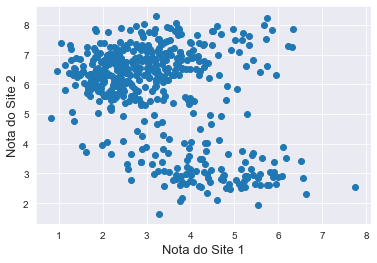

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = dados['avg_site1'], y = dados['nota_site2'])
plt.ylabel('Nota do Site 2', fontsize=13)
plt.xlabel('Nota do Site 1', fontsize=13)
plt.show()

A primeira impressão sobre os dados é que não há somente um grupo de dados, há evidências da existência de dois grupos.


### Outliers

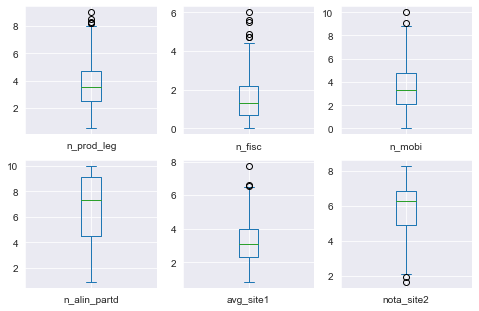

In [7]:
# Box and Whisker Plots
dados.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize= (8,8))

plt.show()

- No primeiro modelo nenhum tratamento foi dado aos outliers

### Variável Target

**nota_site2** é a variável que desejamos predizer, no caso desse problema é a variável que queremos comparar com as variáveis independentes para saber se elas explicam a variabilidade da variável dependente.


 mu = 5.75 and sigma = 1.60



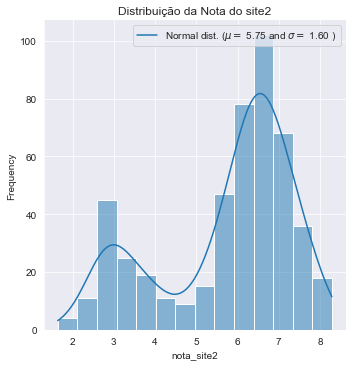

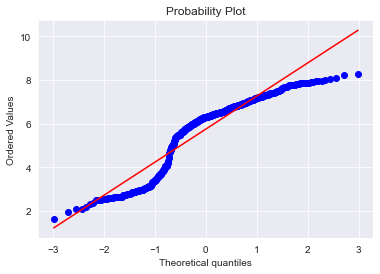

In [8]:
sns.displot(dados['nota_site2'] , kde=True);

# Get the fitted parameters used by the function / 
# Obtendo os parâmetros ajustados usados pela função mu(média), sigma (desvio padrão)
(mu, sigma) = norm.fit(dados['nota_site2'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
# Plotando a distribuição
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Distribuição da Nota do site2')

#Get also the QQ-plot
# Obtenha também o QQ-plot, que é usado para verificar se os resíduos apresentam distribuição normal.
fig = plt.figure()
res = stats.probplot(dados['nota_site2'], plot=plt)
plt.show()

- A curva de densidade suavizada nos mostra que existe uma **distribuição bimodal**. 
 Essa informação é importante pois alguns vezes queremos trabalhar com uma distribuição normal

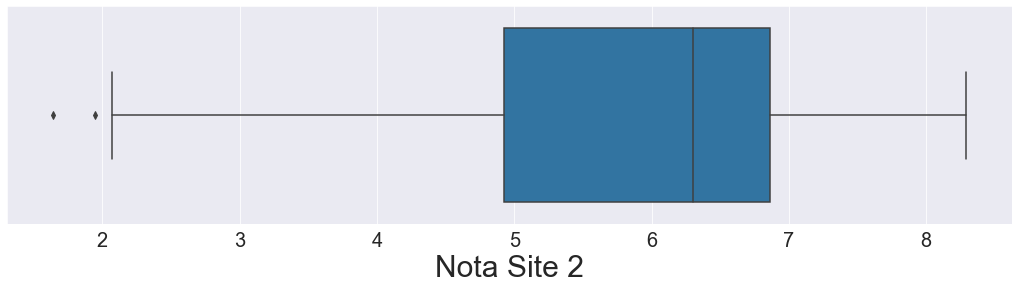

In [9]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
sns.boxplot(x = dados['nota_site2'])
plt.xlabel('Nota Site 2', fontsize =30)
plt.xticks(fontsize=20)
plt.show()

#### Dividindo o dataset em dois conjuntos

E conferindo a distribuição dos dados da variável target

In [10]:
def dist_n(ideologia, n):
    '''Essa função gera um histograma da variável target
    e um QQ-plot, do subset a depender da ideologia ('esquerda', 'direita',
    'centro')
    Se n = 1, o gráfico é gerado com dados de duas ideologias excluindo 
    a informada
    
    Se n != 1, o gráfico é gerado com dados da ideologias informada'''
    
    global dados_ideol_n
    lista_ideol = ['esquerda', 'centro', 'direita']
    if n == 1:
        dados_ideol = dados[dados['ideologia'] != ideologia]
        lista_ideol = [i for i in lista_ideol if i != ideologia]
        print('Ideologias do gráfico:',lista_ideol)
    else:
        dados_ideol = dados[dados['ideologia'] == ideologia]
        print('Ideologia do gráfico:', ideologia)
        
    dados_ideol_n = dados_ideol[colunas]
    
    graf_ideol = sns.displot(dados_ideol_n['nota_site2'] , kde=True, 
                             height=3.5, aspect=1.4);

    # Get the fitted parameters used by the function / 
    # Obtendo os parâmetros ajustados usados pela função mu(média), 
    # sigma (desvio padrão)
    (mu, sigma) = norm.fit(dados_ideol_n['nota_site2'])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    # Plotando a distribuição
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'\
                .format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribuição da Nota do site2')

    #Get also the QQ-plot
    # Obtenha também o QQ-plot, que é usado para verificar se os resíduos 
    # apresentam distribuição normal.
    fig = plt.figure(figsize=(6, 4))
    res = stats.probplot(dados_ideol_n['nota_site2'], plot=plt)
    plt.show()
    
    return graf_ideol

Ideologia do gráfico: esquerda

 mu = 3.32 and sigma = 0.95



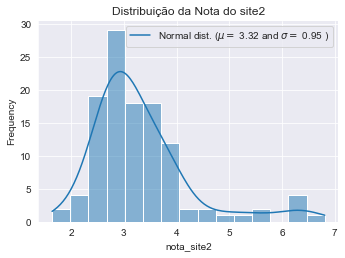

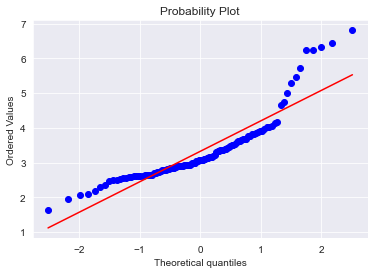

In [11]:
dist_n('esquerda', 0)

### Correlação dos dados

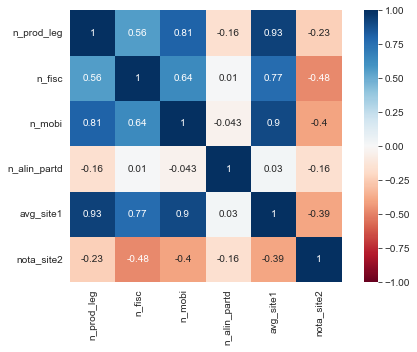

In [12]:
# Mapa de correlação para ver como as features são correlacionadas com a 
# nota do site 2

corrmat = dados_n.corr()
plt.subplots(figsize=(8,5))
sns.heatmap(corrmat, square=True, cmap='RdBu', vmin = -1, annot=True)
plt.show()


In [13]:
numeric_feats = dados_n.dtypes[dados_n.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = dados_n[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
n_fisc,0.905
n_prod_leg,0.650
avg_site1,0.639
n_mobi,0.608
nota_site2,-0.820
n_alin_partd,-0.840


 - Uma regra fala que skewness entre -1 e -0.5 ou 0.5 e 1 é considerada como moderadamente 'Skewed'

A principio vamos manter os dados sem alterações devido a distorção (Skewness)

### Verificações com Matplotlib

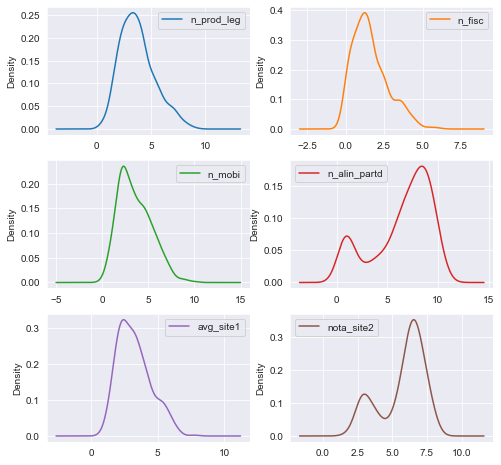

In [14]:
# Density Plot Univariado
dados.plot(kind = 'density', subplots = True, layout = (3,2), sharex = False, figsize= (8,8))

plt.show()

## Criando o Modelo de ML

 - FUNÇÃO DE CUSTO: uma função de custo mede quanto erro tem no modelo em termos da habilidade de estimar a relação entre **x** e **y**. Nós podemos medir a precisão da nossa função hipótese usando a função de custo. Ela pega uma diferença média da variável dependente observada  no dataset fornecido e as previstas pela função de hipótese.
 - EQUAÇÃO NORMAL: a equação normal é uma solução analitica  de um problema de regressão linear com uma função de custo mínimo quadrado ordinário.

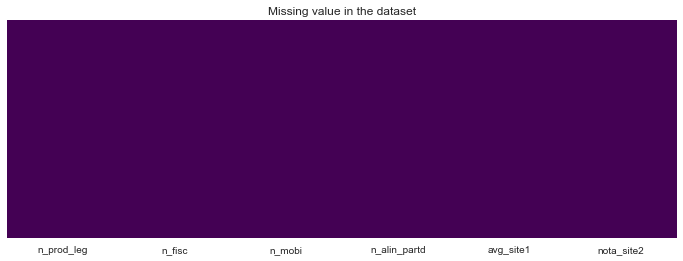

In [15]:
#verificando valores missing
plt.figure(figsize=(12,4))
sns.heatmap(dados_n.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

Não existem valores missing no dataset

### Dividindo os dados em treino e teste

In [16]:
dados_n.head()

,n_prod_leg,n_fisc,n_mobi,n_alin_partd,avg_site1,nota_site2
0,3.800,0.900,2.400,6.400,2.853,6.550
1,2.600,0.200,2.100,6.400,2.029,6.120
2,2.800,0.900,2.400,5.500,2.329,6.820
3,6.400,2.900,7.300,10.000,5.741,8.240
4,2.300,0.000,2.100,10.000,2.041,6.820


In [17]:
X = dados_n.drop(['avg_site1','nota_site2'], axis=1) #variáveis independentes
y = dados_n['nota_site2'] #variável dependente

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3
                                                    ,random_state=42)

### Construindo o modelo

Nessa etapa construir o modelo usando nossa equação de regressão linear   
θ = (X<sup>T</sup>X)<sup>-1</sup>X<sup>T</sup>y. <br>
No primeiro passo precisamos adicionar x<sub>0</sub> = 1

In [18]:
# Passo 1: addicionar x0 =1 ao dataset

X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Passo 2: Construir o modelo (np.matmul - produz uma matriz 
#                              produto de duas arrays
#                              np.linalg.inv, calcula a inversa de uma matriz)

theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) )\
                  , np.matmul(X_train_0.T,y_train))

In [19]:
# parametros de um modelo de regressão linear

parametro = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parametro_df = pd.DataFrame({'Parameter':parametro,'Columns':columns\
                             ,'theta':theta})

In [20]:
# Treinando o modelo pelo Scikit Learn


lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) 
# Nota: não é preciso adicionar x_0=1,  
# sklearn faz isso sozinho.

LinearRegression()

In [21]:
#Parametro
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parametro_df = parametro_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parametro_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,7.416,7.416
1,theta_1,n_prod_leg,0.187,0.187
2,theta_2,n_fisc,-0.566,-0.566
3,theta_3,n_mobi,-0.285,-0.285
4,theta_4,n_alin_partd,-0.070,-0.070


Os parametros foram os mesmo obtidos pelo código criado e pelas funções do ScikitLearn

## Avaliação do modelo

- Iremos prever o valor da variável target usando nosso parâmtro do modelo para o conjunto de dados de teste. Em seguida, comparar o valor previsto com o valor real no conjunto de teste.
- Será usado o R<sup>2</sup>, que é uma medida estatística de quão perto dos dados a linha de regressão está. R<sup>2</sup> é sempre entre 0 e 100%. 0% indica que o modelo não explica a variabilidade dos dados de resposta em torno da sua média. 100% indica que o modelo explica toda a variabilidade dos dados de resposta em torno da média.

##### Pela equação normal

In [22]:
y_pred_norm =  np.matmul(X_test_0,theta)

#Avaliação: MSE (Mean Square Error - Erro quadratico médio)
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R_quadrado
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('O erro quadrático médio (MSE) ou J(theta) é: ',J_mse)
print('R² obtido pelo método da equação normal é:',R_square)

O erro quadrático médio (MSE) ou J(theta) é:  1.7049786600373638
R² obtido pelo método da equação normal é: 0.3062105593781216


#### Pelo Sklearn

In [23]:
# Modulo de regressão do Sklearn
y_pred_sk = lin_reg.predict(X_test)

#Avaliação: MSE

# J_mse_sk = mean_squared_error(y_pred_sk, y_test)
J_mse_sk = mean_squared_error(y_test, y_pred_sk)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)

print('O erro quadrático médio (MSE) ou J(theta) é: ',J_mse_sk)
print('R² obtido pela biblioteca scikit learn é:',R_square_sk)

O erro quadrático médio (MSE) ou J(theta) é:  1.7049786600373653
R² obtido pela biblioteca scikit learn é: 0.3062105593781209


- O modelo retorna um valor do R<sup>2</sup> de 30,62%, então nosso ajuste do não é bom. Pode-se tentar melhorar fazendo mudanças no dataset ou parametros do modelo ou assumir que as componentes da nota do site 1 (LegislaBrasil) não explica a variabilidade do site 2 (Políticos.org).
- Como foi visto através da adição da variável "Ideologia", que classificava os candidatos de acordo com a ideologia do seu partido, há indicios de um viés politíco na nota do site Politicos.org . Pois o mesmo usa um critério para as notas que julga o que é bom ou ruim pela orientação de um conselho, mas não explica como esse conselho é formado, e se há uma diversidade politíca presente.

## Validação do Modelo


- Para validar o modelo precisamo checar algumas hipóteses do modelo de regressão linear. Hipóteses comum para um modelo de regressão linear são: 
    1. Relação linear, a relação entre as variáveis dependentes e independentes devem ser linear.
    2. O plot dos erros residuais  deve ser normalmente distribuídos.
    3. A média do erro residual deveria ser 0 ou o mais próximo de 0 póssível.
    4. A regressão linear requer que todas as variáveis sejam normais multivariadas. Essa hipótese pode ser checada pelo QQ-plot.
    5. Regressão linear assume que existe uma pequena ou não tenha multicolinearidade nos dados. Multicolinearidade occore quando as variáveis independentes são muito correlacionadas umas com as outras. O VIF (variance inflation factor) identifica correlações existentes entre as variáveis independentes e a força dessa correlação. VIF = 1/(1-R²), se VIF > 1 & VIF < 5 há moderada correlação, VIF > 5 há um level crítico de multicolinearidade.
    6. Homocedasticidade, os dados serem homocedástico significa que a variabilidade dos residuos são constantes através da linha de regressão linear. Nós podemos olhar os resíduais x valor ajustado no scatter plot. Se o gráfico for heterocedástico exibiria um padrão de forma de funil. 

#### Checando linearidade

C:\Users\nabuc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nabuc\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


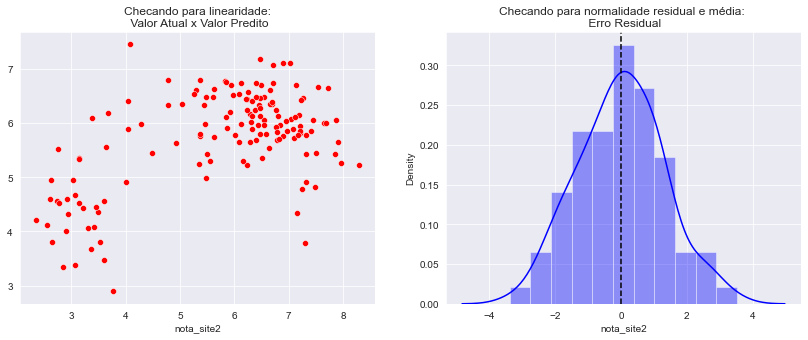

In [24]:
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_sk,ax=ax,color='r')
ax.set_title('Checando para linearidade:\n Valor Atual x Valor Predito')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_sk),ax=ax,color='b')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Checando para normalidade residual e média: \n Erro Residual');

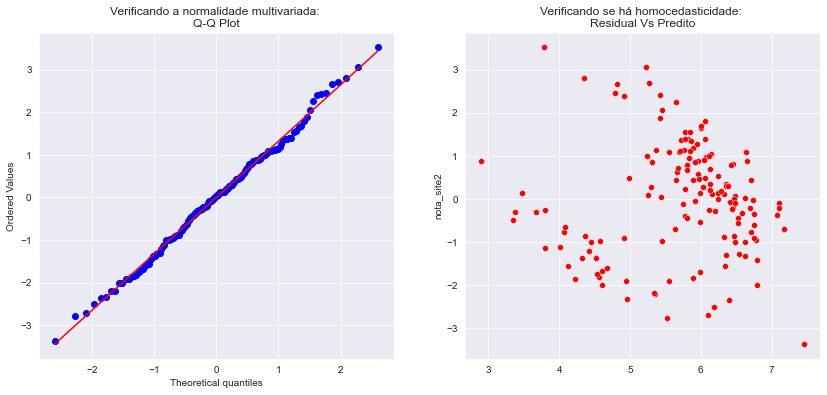

In [25]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Verificando a normalidade multivariada: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Verificando se há homocedasticidade: \nResidual Vs Predito');

In [26]:
# Verificando se há multicolinearidade
# Variance Inflation Factor
VIF = 1/(1- R_square_sk)
VIF

1.4413594982126692

Pela validação do modelo podemos concluir que:<br>
    1. Em nosso modelo o gráfico do Valor Atual x Valor previsto não apresenta linearidade.<br>
    2. A média residual é zero e o gráfico de erro residual é simétrico.<br>
    3. O QQ-plot apresenta que os dados que representam uma distribuição normal.<br>
    4. O gráfico não apresenta homocedasticidade.<br>
    5. O VIF de variância é menor que 5, portanto, não há multicolinearidade.

##### Por apresentar um valor de R² muito baixo e não atender algumas hipóteses para modelos de regressão linear, concluímos que as notas do site 1 não explicam a variabilidade das notas do Site 2.
